# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk

In [2]:
!python clean_results.py

In [3]:
df = pd.read_csv('results/results_clean.csv')
print(df.dtypes)
df.head()


method          object
test_scores     object
train_scores    object
basis           object
lag_time         int64
n_components     int64
n_clusters       int64
dtype: object


,method,test_scores,train_scores,basis,lag_time,n_components,n_clusters
0,bayesian,"[1.3776911158951748, 1.3740749840217341, 1.264...","[2.9389462312306645, 2.950642052871998, 2.9298...",close_cont,868,7,216
1,bayesian,"[1.0684842211915222, 1.1161358818514298, 1.143...","[2.0313664449993496, 1.902029834442478, 1.9717...",chi_tor,123,8,719
2,bayesian,"[1.419293959877178, 2.459780516990084, 1.42471...","[2.9952122086182973, 2.9991551430503254, 2.996...",alpha_angle,528,9,503
3,bayesian,"[1.266771869867596, 2.1699129867494955, 2.1975...","[2.9829218758783957, 2.994692237174925, 2.9937...",all_tor,909,6,245
4,bayesian,"[1.502631858780357, 2.094233568665083, 1.25880...","[2.998903280162028, 2.993679670790958, 2.99892...",close-h_cont,228,10,990


In [4]:
df.loc[:, 'id'] = np.arange(df.shape[0])+1

Convert score fields to numeric lists, not strings. 

In [5]:
def to_float(x):
    nums = re.findall('[0-9]+\\.[0-9]+', string=x)
    nums = [float(y) for y in nums]
    return nums

df.loc[:, 'test_scores'] = df.loc[:, 'test_scores'].apply(to_float)
df.loc[:, 'train_scores'] = df.loc[:, 'train_scores'].apply(to_float)

Expand out the individual list scores and label the fold numbers

In [6]:
lst_cols = ['test_scores', 'train_scores']
n_folds = df[lst_cols[0]].str.len()[0] # Assumes all the lists are the same length! 

df_long = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
      for col in df.columns.drop(lst_cols)}
    ).\
assign(fold_num = np.concatenate([np.arange(1, x+1) for x in df[lst_cols[0]].str.len()])).\
assign(**{lst_col:np.concatenate(df[lst_col].values) for lst_col in lst_cols })


In [7]:
df_long.query('method=="random"')

,method,basis,lag_time,n_components,n_clusters,id,fold_num,test_scores,train_scores
7835,random,all_tor,861,8,424,1568,1,1.909310,2.947081
7836,random,all_tor,861,8,424,1568,2,1.698505,2.996456
7837,random,all_tor,861,8,424,1568,3,2.276155,2.995918
7838,random,all_tor,861,8,424,1568,4,1.649213,2.786009
7839,random,all_tor,861,8,424,1568,5,1.687259,2.997979
...,...,...,...,...,...,...,...,...,...
20630,random,ppo_tor,230,8,724,4127,1,1.683005,2.995281
20631,random,ppo_tor,230,8,724,4127,2,1.141850,2.999343
20632,random,ppo_tor,230,8,724,4127,3,1.369045,2.994739
20633,random,ppo_tor,230,8,724,4127,4,2.064755,2.751816


Rescale the lag time 

In [8]:
df_long['lag_time'] *= 0.5

Rename the columns

In [9]:
df_long.rename(columns={'test_scores': 'test_score', 'train_scores': 'train_score'}, inplace=True)

In [10]:
df_basis_method = df_long.loc[:, ['id', 'basis', 'method']].drop_duplicates()

In [11]:
df_basis_method.head()

,id,basis,method
0,1,close_cont,bayesian
5,2,chi_tor,bayesian
10,3,alpha_angle,bayesian
15,4,all_tor,bayesian
20,5,close-h_cont,bayesian


In [12]:
df_ave = df_long.groupby('id').mean().reset_index()
df_ave = df_basis_method.merge(df_ave, on='id', how='inner')

## Fit model - ppo torsions only
### n_clusters only

First generate a data matrix

In [13]:
ppo_rand_idx = (df_ave['basis']=='ppo_tor') & (df_ave['method'] == 'random')

form = 'test_score ~ -1 + n_clusters + lag_time + n_components'
y_obs, x_obs = pt.dmatrices(form, df_ave.loc[ppo_rand_idx, :], return_type='dataframe')

Scale each value to be in the interval (0, 1)

In [14]:
from sklearn.preprocessing import MinMaxScaler
unit_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = pd.DataFrame(unit_scaler.fit_transform(x_obs), columns=x_obs.columns)
x_scaled.head()

,n_clusters,lag_time,n_components
0,0.460914,0.028283,0.666667
1,0.718782,0.863636,0.111111
2,0.422335,0.117172,1.000000
3,0.893401,0.569697,0.111111
4,0.539086,0.482828,0.444444


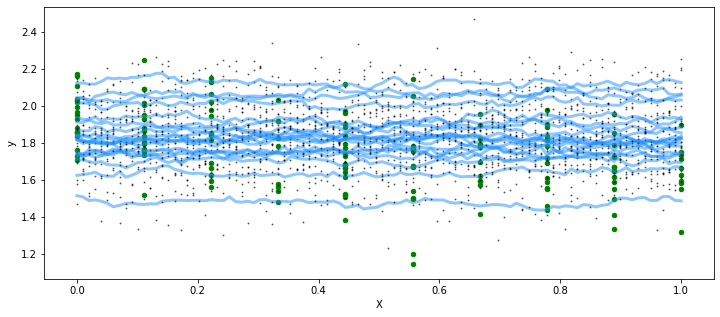

In [15]:
# set the seed
np.random.seed(1)
fig, ax = plt.subplots(figsize=(12,5))
n = 100 # The number of data points
X = np.linspace(0, 1, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = .1
a_true = 0.001
eta_true = 0.2
cov_func = eta_true**2 * pm.gp.cov.RatQuad(1, alpha=a_true, ls=l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Constant(c=1.8)

for i in range(20):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                          cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

    # The observed data is the latent function plus a small amount of T distributed noise
    # The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
    sigma_true = 0.1
    y = f_true + np.random.normal(size=n, loc=0, scale=sigma_true)

    ## Plot the data and the unobserved latent function

    ax.plot(X, f_true, "dodgerblue", lw=3, label="True f", alpha=0.5);
    ax.plot(X, y, 'ok', ms=1, label="Data",alpha=0.5);
    ax.set_xlabel("X"); ax.set_ylabel("y");


ax.scatter(x_scaled.loc[:, 'n_components'].values, y_obs, color='g', s=20, alpha=1)

## Three variables - RBF Kernel

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 47.147, ||grad|| = 0.073885: 100%|██████████| 26/26 [00:00<00:00, 178.66it/s]  


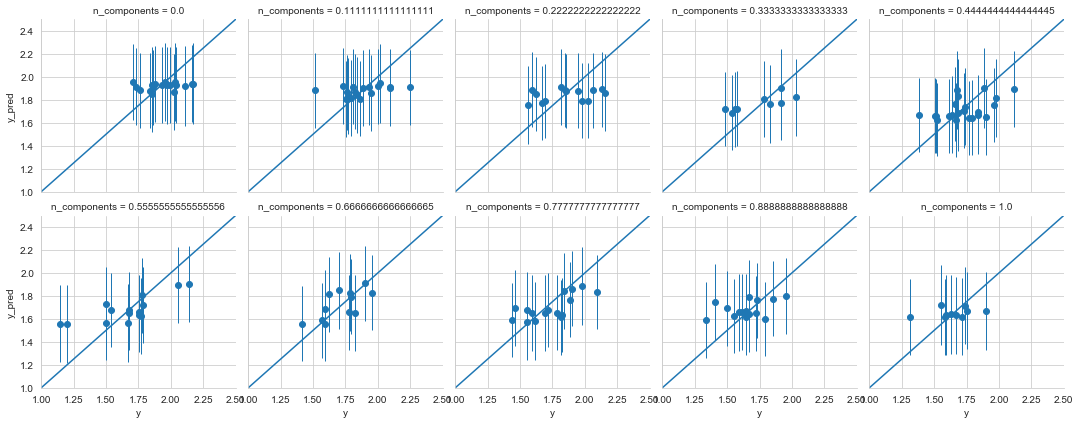

In [75]:
with pm.Model() as model2:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2 * pm.gp.cov.ExpQuad(X.shape[1], ls=l_n, active_dims=[0])
    cov = cov * pm.gp.cov.ExpQuad(X.shape[1], ls=l_tau, active_dims=[1])
    cov = cov * pm.gp.cov.ExpQuad(X.shape[1], ls=l_m, active_dims=[2])
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp2 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp2, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res2 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res2, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])
    

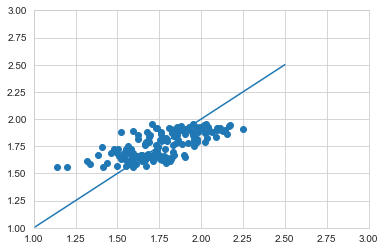

In [76]:
plt.scatter(res2.loc[:, 'y'], res2.loc[:, 'y_pred'] )
plt.xlim(1, 3)
plt.ylim(1, 3)
plt.plot([1, 2.5], [1, 2.5])

### with Exponential kernel

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packag

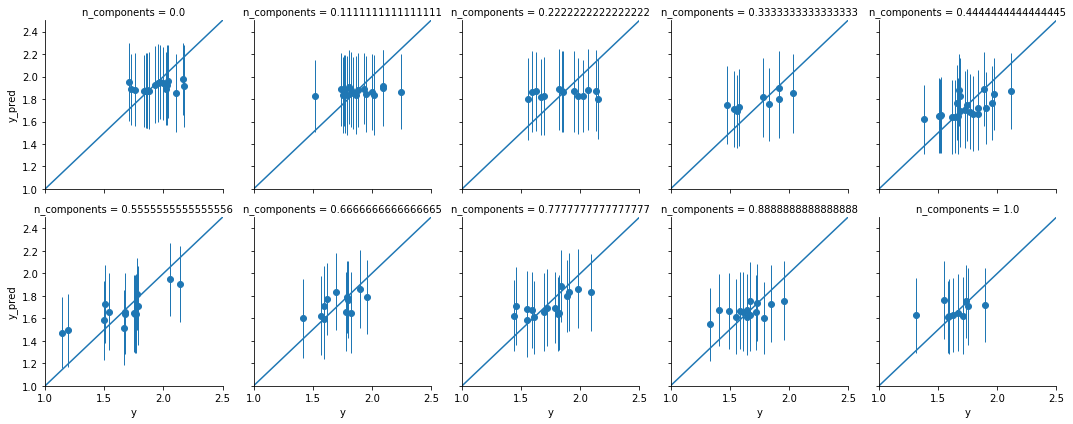

In [18]:
with pm.Model() as model3:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2 * pm.gp.cov.Exponential(X.shape[1], ls=l_n, active_dims=[0])
    cov = cov * pm.gp.cov.Exponential(X.shape[1], ls=l_tau, active_dims=[1])
    cov = cov * pm.gp.cov.Exponential(X.shape[1], ls=l_m, active_dims=[2])
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp3 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp3, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res3 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res3, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])

### With RBF Kronecker product kernel

logp = 46.695, ||grad|| = 0.0022071: 100%|██████████| 23/23 [00:00<00:00, 194.61it/s]  


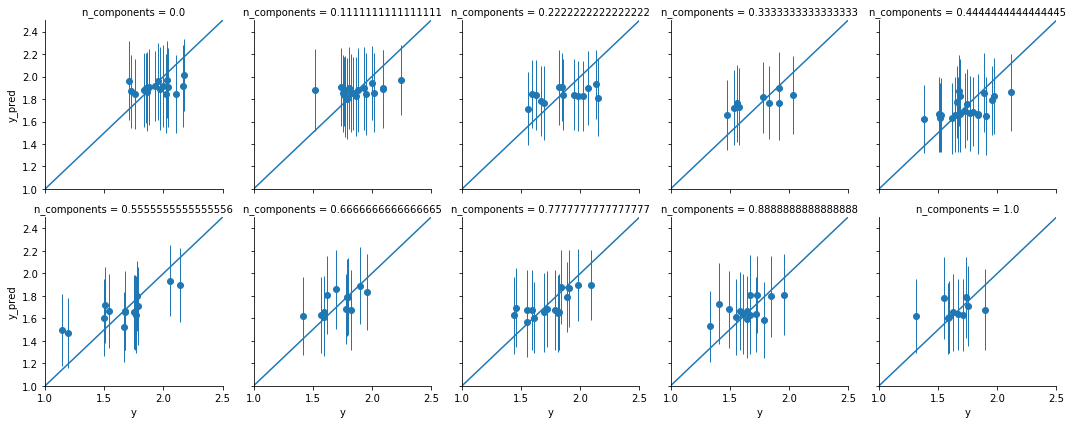

In [19]:
with pm.Model() as model4:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov1 = eta**2 * pm.gp.cov.Exponential(1, ls=l_n)
    cov2 = pm.gp.cov.Exponential(1, ls=l_tau)
    cov3 = pm.gp.cov.Exponential(1, ls=l_m)
    
    cov = pm.gp.cov.Kron([cov1, cov2, cov3])
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp4 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp4, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res4 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res4, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])

### With Matern52

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packag

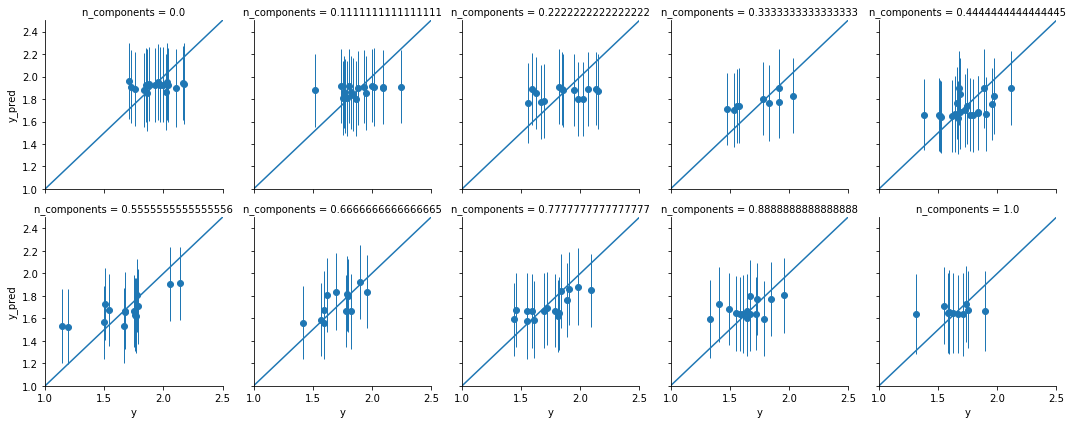

In [20]:
with pm.Model() as model5:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2 * pm.gp.cov.Matern52(X.shape[1], ls=l_n, active_dims=[0])
    cov = cov * pm.gp.cov.Matern52(X.shape[1], ls=l_tau, active_dims=[1])
    cov = cov * pm.gp.cov.Matern52(X.shape[1], ls=l_m, active_dims=[2])
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp5 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp5, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res5 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res5, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])

### With additive RBF

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 32.199, ||grad|| = 0.0088127: 100%|██████████| 50/50 [00:00<00:00, 111.29it/s] 


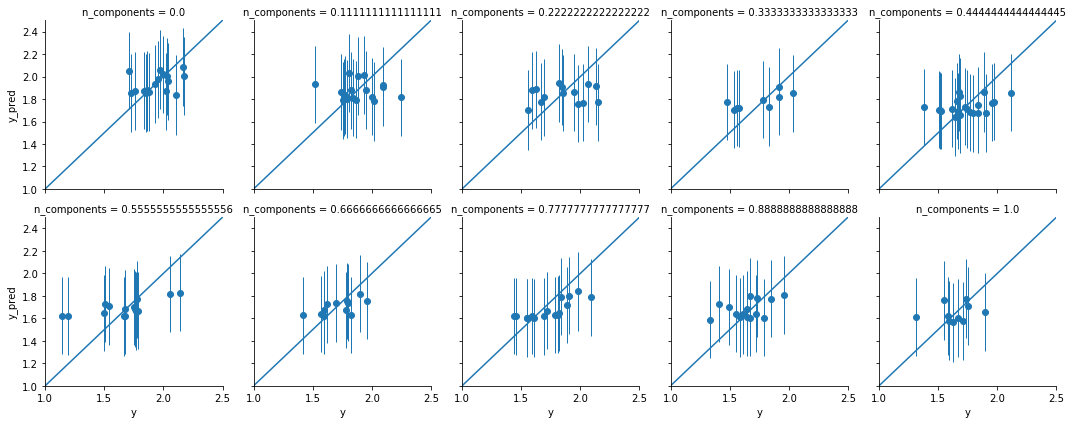

In [21]:
with pm.Model() as model6:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = pm.gp.cov.Matern52(X.shape[1], ls=l_n, active_dims=[0])
    cov = cov + pm.gp.cov.Matern52(X.shape[1], ls=l_tau, active_dims=[1])
    cov = cov + pm.gp.cov.Matern52(X.shape[1], ls=l_m, active_dims=[2])
#     cov =  eta**2*cov
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp6 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp6, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res6 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res6, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])

### With rational quadratic

In [23]:
with pm.Model() as model7:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 50
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)
    
    a_n = pm.Gamma("a_n", alpha=0.5, beta=1)
    a_tau = pm.Gamma("a_tau", alpha=0.5, beta=1)
    a_m = pm.Gamma("a_m", alpha=0.5, beta=1)
    
    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2*pm.gp.cov.RatQuad(X.shape[1], alpha=a_n, ls=l_n, active_dims=[0])
    cov = cov*pm.gp.cov.RatQuad(X.shape[1], alpha=a_tau, ls=l_tau, active_dims=[1])
    cov = cov*pm.gp.cov.RatQuad(X.shape[1], alpha=a_m, ls=l_m, active_dims=[2])
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp7 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp7, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res7 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res7, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    g.set(xlim=(1, 2.5), ylim=(1, 2.5))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, 2.5], [1, 2.5])

logp = 76.327, ||grad|| = 1.9409e+19:   0%|          | 23/5000 [00:00<00:42, 118.36it/s]


ValueError: array must not contain infs or NaNs
Apply node that caused the error: Cholesky{lower=True, destructive=False, on_error='raise'}(Elemwise{Composite{((((i0 + ((i1 * clip((i2 + i3 + i4), i5, i6)) / i7)) ** i8) * i9 * ((i0 + ((i1 * clip((i10 + i11 + i12), i5, i6)) / i13)) ** i14) * ((i0 + ((i1 * clip((i15 + i16 + i17), i5, i6)) / i18)) ** i19)) + i20)}}[(0, 2)].0)
Toposort index: 71
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(50, 50)]
Inputs strides: [(400, 8)]
Inputs values: ['not shown']
Outputs clients: [[Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}(Cholesky{lower=True, destructive=False, on_error='raise'}.0, Elemwise{Composite{(((i0 + ((i1 * clip((i2 + i3 + i4), i5, i6)) / i7)) ** i8) * i9 * ((i0 + ((i1 * clip((i10 + i11 + i12), i5, i6)) / i13)) ** i14) * ((i0 + ((i1 * clip((i15 + i16 + i17), i5, i6)) / i18)) ** i19))}}[(0, 2)].0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-47cdbab609d9>", line 25, in <module>
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/gp/gp.py", line 717, in marginal_likelihood
    return pm.DensityDist(name, logp, observed=y, **kwargs)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 47, in __new__
    return model.Var(name, dist, data, total_size)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/model.py", line 952, in Var
    total_size=total_size, model=self)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/model.py", line 1492, in __init__
    self.logp_nojac_unscaledt = distribution.logp_nojac(data)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 116, in logp_nojac
    return self.logp(*args, **kwargs)
  File "/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/gp/gp.py", line 647, in _build_marginal_likelihood_logp
    Luu = cholesky(stabilize(Kuu))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Fit model using individual fold data

In [24]:
ppo_rand_idx = (df_long['basis']=='ppo_tor') & (df_long['method'] == 'random')

form = 'test_score ~ -1 + n_clusters + lag_time + n_components'
y_obs, x_obs = pt.dmatrices(form, df_long.loc[ppo_rand_idx, :], return_type='dataframe')

unit_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = pd.DataFrame(unit_scaler.fit_transform(x_obs), columns=x_obs.columns)
x_scaled.head()

,n_clusters,lag_time,n_components
0,0.460914,0.028283,0.666667
1,0.460914,0.028283,0.666667
2,0.460914,0.028283,0.666667
3,0.460914,0.028283,0.666667
4,0.460914,0.028283,0.666667


 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = -324.24, ||grad|| = 0.056786: 100%|██████████| 25/25 [00:01<00:00, 17.54it/s]  


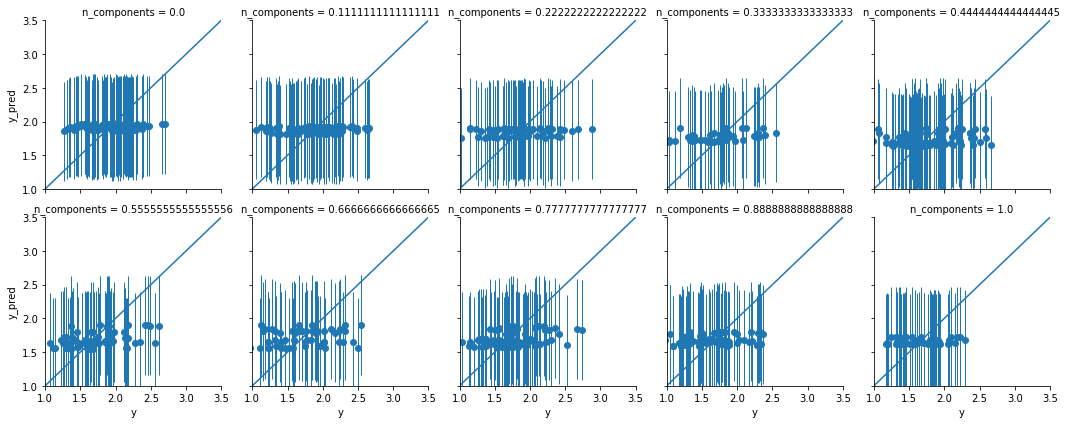

In [25]:
with pm.Model() as model8:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time', 'n_components']].values, y_obs.values.T[0]
    num_u = 200
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)
    l_m = pm.Gamma("l_m", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2 * pm.gp.cov.ExpQuad(X.shape[1], ls=l_n, active_dims=[0])
    cov = cov * pm.gp.cov.ExpQuad(X.shape[1], ls=l_tau, active_dims=[1])
    cov = cov * pm.gp.cov.ExpQuad(X.shape[1], ls=l_m, active_dims=[2])
    
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp8 = pm.find_MAP()
    
    mu, var = gp.predict(X, point=mp8, diag=True,pred_noise=True)
    sd = np.sqrt(var)
    
    res8 = pd.DataFrame({'n_clusters': X[:, 0], 'time_lag': X[:, 1], 
                        'n_components': X[:, 2], 'y': y, 'y_pred': mu, 
                        'err':2*sd})
    g = sns.FacetGrid(data=res8, col='n_components', col_wrap=5)
    g.map(plt.errorbar,'y','y_pred', 'err', lw=0, elinewidth=1, marker='o')
    ylim = 3.5
    g.set(xlim=(1, ylim), ylim=(1, ylim))
    for i, ax in enumerate(g.axes.flatten()):
        ax.plot([1, ylim], [1, ylim])
    

## RBF results analysis

Recalculate the scaled values so we can invert the values

In [77]:
ppo_rand_idx = (df_ave['basis']=='ppo_tor') & (df_ave['method'] == 'random')

form = 'test_score ~ -1 + n_clusters + lag_time + n_components'
y_obs, x_obs = pt.dmatrices(form, df_ave.loc[ppo_rand_idx, :], return_type='dataframe')

unit_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = pd.DataFrame(unit_scaler.fit_transform(x_obs), columns=x_obs.columns)


Calculate residuals and rename the scaled variables to avoid confusion when the original are put back .

In [78]:
res2['e_lower'] = res2['y']-(res2['y_pred']+res2['err'])
res2['e_upper'] = res2['y']-(res2['y_pred']-res2['err'])
res2['e'] = res2['y']-res2['y_pred']

res2.rename(columns={'n_clusters':'n_clusters_s', 'time_lag':'time_lag_s', 'n_components':'n_components_s'}, 
            inplace=True)

res2 = res2.join(pd.DataFrame(unit_scaler.inverse_transform(res2.loc[:, ['n_clusters_s', 'time_lag_s', 'n_components_s']]),columns=['n_clusters', 'time_lag', 'n_components']))

The predictions are grouped so let's cut these into two groups and analyse them to make sure nothing funny is going on. 

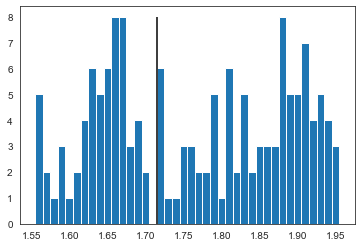

In [144]:
c, bins, _ = plt.hist(res2['y_pred'], bins=40)
y_pred_cut_point = bins[1:][c==0]
plt.vlines(y_pred_cut_point, 0, 8)

Cut the n_clusters,  time_lag and y_prediciton variables

In [178]:
res2['n_clusters'] = res2['n_clusters'].astype(int)
to_cut = ['n_clusters', 'time_lag']
precisions = [0, 1]
n_quants = 4 # n quantiles gives us n-1 categories
for i, var in enumerate(to_cut):
    res2.loc[:, var+'_cut'] = pd.cut(res2[var], np.quantile(res2[var], np.linspace(0, 1, n_quants),  
                                                                                   interpolation='nearest'), 
                                    include_lowest=True, precision=precisions[i])

to_cut = ['y_pred']
n_quants = 4 # n quantiles gives us n-1 categories
for var in to_cut:
    res2.loc[:, var+'_cut'] = pd.cut(res2[var], bins=[np.min(res2[var]), y_pred_cut_point[0], np.max(res2[var])], 
                                    include_lowest=True, precision=2)


In [263]:
def residual_plot(results_df):


    with sns.plotting_context('paper', font_scale=1.25):
        sns.set_style('whitegrid')

        results_df['n_components_j'] = results_df['n_components']+np.random.normal(size=res2.shape[0], loc=0, scale=0.1)

        res_renamed = results_df.rename(columns={'n_components_j':'TICA components', 
                                           'n_clusters_cut': 'No. clusters', 
                                          'time_lag_cut': r'TICA $\tau$', 
                                          'e': r'$y-\hat{y}$', 
                                            'y_pred_cut': r'$\hat{y}$'})


        g = sns.FacetGrid(data=res_renamed, col='No. clusters', row=r'TICA $\tau$', margin_titles=True,
                          legend_out=True)
        
        g.map(plt.errorbar, 'TICA components', r'$y-\hat{y}$', 'err', 
              lw=0, elinewidth=2, marker='o',ms=10, alpha=0.5).add_legend()
    #     g.set(ylabel='residual', xlabel='n_components')

        for i, ax in enumerate(g.axes.flatten()):
            ax.hlines(0, 0, 11, lw=1)
            ax.xaxis.set_major_locator(tk.FixedLocator(locs=np.arange(1, 11,1)))
            ax.annotate('({})'.format(list('abcdefghi')[i]), xy=(0.1, 0.95), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
    
    return fig, ax

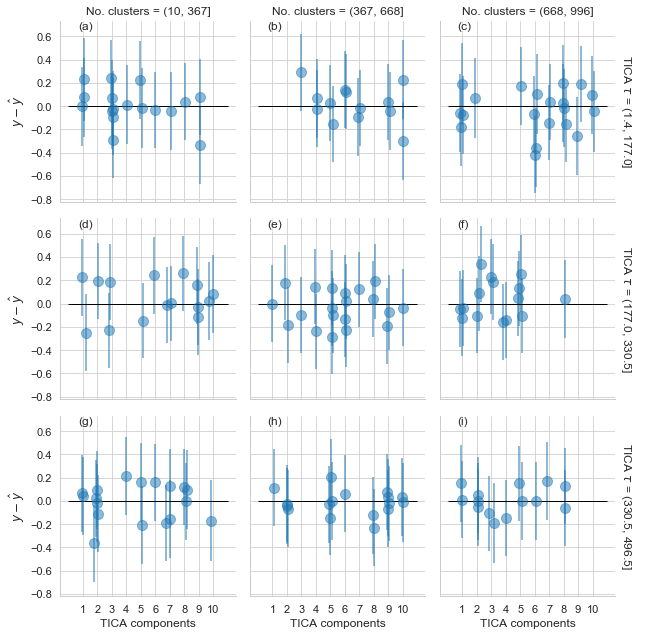

In [264]:
fig, ax = residual_plot(res2)
plt.savefig('figures/residual_plot_detail_random_ppo_rbf.png', bbox_inches='tight')

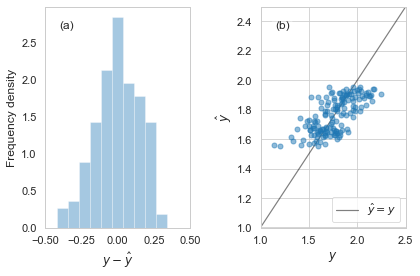

In [268]:
with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
    
    cols = sns.color_palette('colorblind')
    cols = np.array([(*x, 1) for x in cols])



    fig, axes = plt.subplots(1, 2)
    sns.distplot(res2['e'], kde=False, ax=axes[0], norm_hist=True)
    axes[0].set_xlim(-0.5, 0.5)
    axes[0].set_ylabel('Frequency density')
    axes[0].set_xlabel(r'$y-\hat{y}$')
    axes[0].grid(lw=0)
    axes[1].errorbar(x=res2['y'],y=res2['y_pred'], yerr=res2['err'], 
                     lw=0, elinewidth=0, marker='o',ms=5, alpha=0.5, 
                   )


    axes[1].set_ylabel(r'$\hat{y}$')
    axes[1].set_xlabel(r'$y$')

    axes[1].set_xlim(1, 2.5)
    axes[1].set_ylim(1, 2.5)
    axes[1].plot([1, 2.5], [1, 2.5], color='k', alpha=0.5, label=r'$\hat{y}=y$')
    axes[1].legend(loc='lower right')
    for i, ax in enumerate(axes.flatten()):
        ax.annotate('({})'.format(list('abcdefghi')[i]), xy=(0.1, 0.9), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
    plt.tight_layout()
    plt.savefig('figures/residual_plot_random_ppo_rbf.png', bbox_inches='tight')  

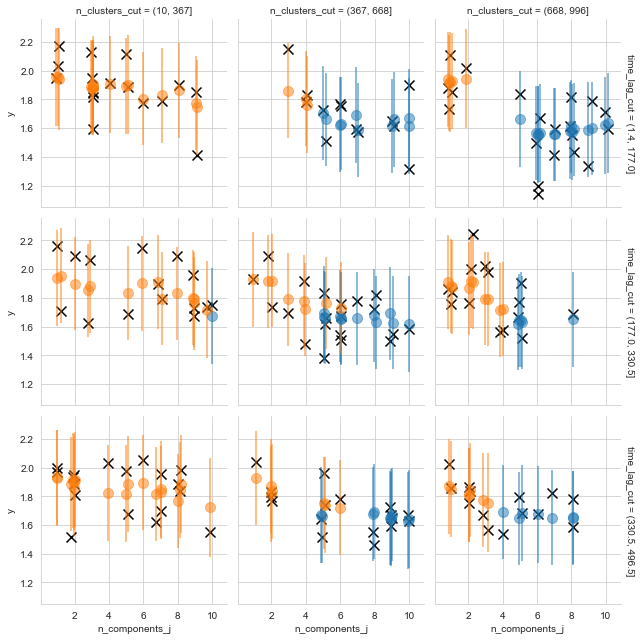

In [279]:
g = sns.FacetGrid(data=res2, col='n_clusters_cut', row=r'time_lag_cut', margin_titles=True,
                  legend_out=True, hue='y_pred_cut')

g.map(plt.errorbar, 'n_components_j', 'y_pred', 'err', 
      lw=0, elinewidth=2, marker='o',ms=10, alpha=0.5)
# g.map(plt.scatter, 'n_components_j', 'y', 
#        marker='x',s=100, color='k', alpha=1)